In [1]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# indicate address for chosen URL
url = "https://www.rigzone.com/news/what_could_omicron_cost_global_oil_market-03-dec-2021-167199-article"
# open the URL for reading
html = urllib.request.urlopen(url)
# parsing the html file
htmlParse = BeautifulSoup(html, 'html.parser')

parsed_text = ""

for para in htmlParse.find_all("p"):
    #parsed_text_str += str(para.get_text())
    parsed_text = " ".join((parsed_text, str(para.get_text())))
    
    
sentences = [[i] for i in nlp(parsed_text).sents]

In [3]:
myheaders = ['sentence']
myvalues = sentences
filename = 'article_text.csv'
with open(filename, 'w',newline='') as myfile:
    writer = csv.writer(myfile)
    writer.writerow(myheaders)
    writer.writerows(myvalues)

In [5]:
csv_sentences = pd.read_csv("article_text.csv")

In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [8]:
get_entities('The film had 200 patents')

['film', '200  patents']

In [9]:
entity_pairs = []
for i in tqdm(csv_sentences['sentence']):
  entity_pairs.append(get_entities(i))

100%|██████████| 37/37 [00:00<00:00, 83.16it/s]


In [10]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [12]:
relations = [get_relation(i) for i in tqdm(csv_sentences['sentence'])]


100%|██████████| 37/37 [00:00<00:00, 38.36it/s]


In [13]:
pd.Series(relations).value_counts()

ssdl                            2
announced                       2
That                            2
said in                         2
added in                        2
is                              2
Cases                           1
been                            1
shows                           1
risen for                       1
reported to                     1
revealed                        1
impacted                        1
email                           1
andreas.exarheas@rigzone.com    1
think                           1
added                           1
admitted                        1
said                            1
cost                            1
“                               1
highlighted                     1
see                             1
show                            1
warned                          1
fall by                         1
Impact                          1
hope                            1
fall to                         1
noted         

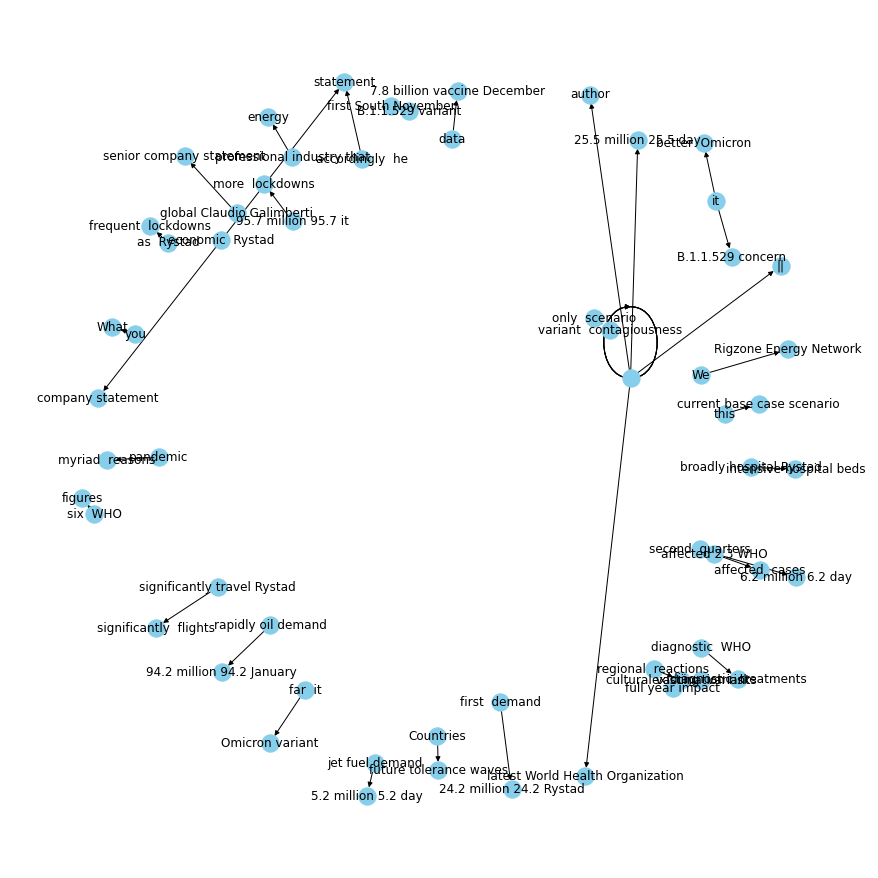

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

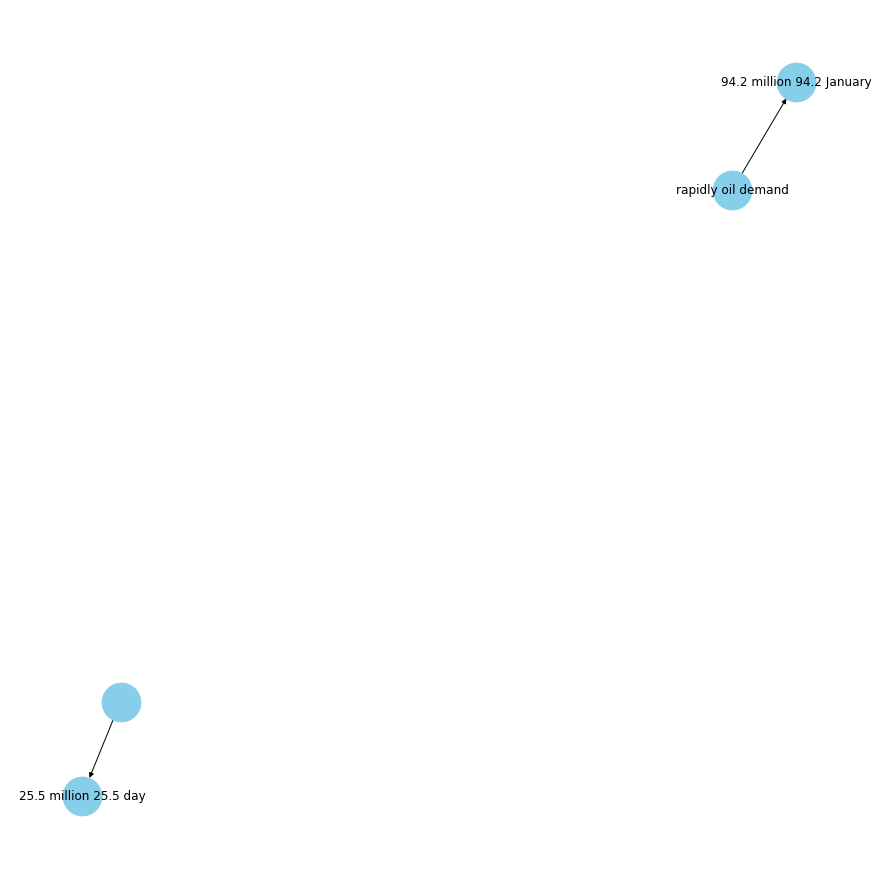

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="That"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [19]:
kg_df

,source,target,edge
0,,,ssdl
1,,||,ssdl
2,95.7 million 95.7 it,more lockdowns,cost
3,rapidly oil demand,94.2 million 94.2 January,That
4,full year impact,existing variant,noted
5,this,current base case scenario,fall to
6,global Claudio Galimberti,senior company statement,said in
7,only scenario,variant contagiousness,hope
8,accordingly he,statement,added in
9,,,Impact
